The code below can be divided into three parts. First, functions define_cell, define_geometry, define_point_sources, define_simulation should be run to initialise the design and simulation cell. end_simulation can be used at any point to reset the values. 

Then, there is a set of functions which can be run separetely (with one exception) to get results from some monitors:

get_epsilon outputs the design structure in XZ plane, can be used to check whether we initated the geometry correctly
get_ldos    outputs a local density of states of the cavity and return the wavelength at which the peak is visible (it uses max             function, so if there is no prominent peak, the result will not be true)
get_qs      outputs first quality factor at the position of point source
get_Er_field outputs Er field in XZ plane, centered at the point source 
get_ratio_power outputs power emitted in upward directions vs total power emitted by the source. It has to be run after defining                 monitors around the source 

Most of these will run their own simulations (less monitors can decrease the simulation time, you can also adjust the time_after_sources value and resolution depending on the monitor you are focusing on). To run only one simulation with all the monitors, use run_all function. Then, you can extract all the values above with extract_ldos, extract_qs, extract_Er_field, extract_ratio_power. 

In [1]:
import meep as mp
import math
import numpy as np
import matplotlib.pyplot as plt
import argparse
import cmath

from meep.materials import Au, SiO2

Ac = mp.Medium(index=1.8)
TiO2 = mp.Medium(index=2.67)
Air = mp.Medium(index=1)

In [15]:
class Bullseye:
    
    def __init__(self, period, diameter, filling_factor, num, dau, ddev, dsio2, dac):
        
        self.period = period                        # period of gratings
        self.diameter = diameter                    # diameter of cavity disk
        self.filling_factor = filling_factor        # filling factor of gratings
        self.num = num                              # number of gratings
        self.dau = dau                              # thickness of gold back-reflector
        self.ddev = ddev                            # thickness of device layer (TiO2)
        self.dsio2 = dsio2                          # thickness of SiO2 spacer
        self.dac = dac                              # thickness of Ac on top of structure
        
        self._cell = None
        self._dimensions = mp.CYLINDRICAL
        self._geometry = None
        self._sources = None
        self._sim = None
        
    def define_cell(self, dpml, pad):
        
        self.dpml = dpml
        self.pad = pad
        
        self.sr = (self.num+1-self.filling_factor)*self.period+self.diameter/2+self.pad+self.dpml  # cell size in r direction
        self.sz = 2*(self.dpml+self.pad)+self.dau+self.ddev+self.dsio2                               # cell size in z direction
        
        self._cell = mp.Vector3(self.sr, 0, self.sz)  # define the cell size
        
    def define_geometry(self):
        
        if self._cell is not None:
            self._geometry = []
            
            self._geometry.append(mp.Block(size=mp.Vector3(self.sr,0,self.ddev),            # Add TiO2 device layer
                     center=mp.Vector3(self.sr/2,0,0),
                     material=TiO2))

            self._geometry.append(mp.Block(size=mp.Vector3(self.sr,0,self.dsio2),           # Add SiO2 spacer layer 
                     center=mp.Vector3(self.sr/2,0,-(self.ddev+self.dsio2)/2),   
                     material=SiO2))

            self._geometry.append(mp.Block(size=mp.Vector3(self.sr,0,self.dau),             # Add Au back reflector
                     center=mp.Vector3(self.sr/2,0,-(self.ddev+self.dau)/2-self.dsio2),
                     material=Au))

            self._geometry.append(mp.Block(size=mp.Vector3(self.sr,0,self.dac),             # Add Ac on top of structure
                     center=mp.Vector3(self.sr/2,0,self.ddev/2+self.dac/2),
                     material=Ac))

            for n in range (0,self.num+1,+1):                                        # Add N+1 etches (N gratings)
                self._geometry.append(mp.Block(size=mp.Vector3((1-self.filling_factor)*self.period, 0, self.ddev),
                                               center=mp.Vector3(self.diameter/2+(1-self.filling_factor)*self.period/2+n*self.period,0,0), 
                                               material=Air))
        
        else:
            raise Exception('Need a cell before defining geometry')
            
            
    def define_point_sources(self, wvl_min, wvl_max, shift):
        
        if self._geometry is not None:
        
            self.wvl_min = wvl_min
            self.wvl_max = wvl_max
            self.shift = shift         # Shift of the source position from the cavity surface in z direction 
        
            self.wvl_cen = 0.5*(self.wvl_min+self.wvl_max)
            self.fmin = 1/self.wvl_max             # min frequency
            self.fmax = 1/self.wvl_min             # max frequency
            self.fcen = 0.5*(self.fmin+self.fmax)  # center frequency
            self.df = self.fmax-self.fmin          # frequency width
            self._sources = mp.Source(mp.GaussianSource(self.fcen, fwidth=self.df), component=mp.Er, 
                                      center=mp.Vector3(0,0,self.ddev/2+self.shift))  #Add dipole-like source
        
        else:
            raise Exception('Need a geometry before defining sources')

        
    def define_simulation(self, res=100, m=+1, Courant = 0.5):
        
        if (self._cell is not None) & (self._geometry is not None) & (self._sources is not None):
            self.res = res
            self.Courant = Courant
            pml_layers = [mp.PML(self.dpml)]

            self._sim = mp.Simulation(cell_size=self._cell,
                                             geometry=self._geometry,
                                             boundary_layers=pml_layers,
                                             resolution=res,
                                             sources=[self._sources],
                                             dimensions=self._dimensions,
                                             m=m,
                                             Courant = self.Courant,
                                             default_material = Air,
                                             progress_interval = 60
                                     )
        else:
            raise Exception('Environment not fully defined. Need a cell, geometry and sources')
            
    
    def end_simulation(self):
        self._sim.reset_meep()
        self._cell = None
        self._geometry = None
        self._sources = None
        self._sim = None
            
      
    def define_box_monitors(self, wvl_flux_min, wvl_flux_max, box_distance, nfreq_box): 
        # Define flux monitor encompassing the source from all directions
        
        if self._sim is not None:
            
            self.wvl_flux_min = wvl_flux_min
            self.wvl_flux_max = wvl_flux_max
        
            self.wvl_flux_cen = 0.5*(self.wvl_flux_min+self.wvl_flux_max)
            self.fmin_flux = 1/self.wvl_flux_max                  # min frequency
            self.fmax_flux = 1/self.wvl_flux_min                  # max frequency
            self.fcen_flux = 0.5*(self.fmin_flux+self.fmax_flux)  # center frequency
            self.df_flux = self.fmax_flux-self.fmin_flux          # frequency width
        
            self.box_dis = box_distance                 # Distance of monitors from the source
            self.nfreq_box = nfreq_box
        
            self.box_z1 = self._sim.add_flux(self.fcen_flux, self.df_flux, self.nfreq_box, 
                                         mp.FluxRegion(center=mp.Vector3(0,0,self.ddev/2+self.shift-self.box_dis),
                                                       size=mp.Vector3(2*self.box_dis)))
            self.box_z2 = self._sim.add_flux(self.fcen_flux, self.df_flux, self.nfreq_box, 
                                         mp.FluxRegion(center=mp.Vector3(0,0,self.ddev/2+self.shift+self.box_dis),
                                                       size=mp.Vector3(2*self.box_dis)))
            self.box_r = self._sim.add_flux(self.fcen_flux, self.df_flux, self.nfreq_box, 
                                        mp.FluxRegion(center=mp.Vector3(self.box_dis,0,self.ddev/2+self.shift),
                                                      size=mp.Vector3(z=2*self.box_dis)))
                                             
        else:
            raise Exception('Cannot run null simulation')
            

    def get_epsilon(self):  # This won't show the Au layer, since it is the only material from the meep library which accounts 
                            # for dispersion and meep doesn’t know at which frequency to output epsilon
        if self._sim is not None:
            
            self._sim.init_fields()
            self.eps_data = self._sim.get_array(center=mp.Vector3(0,0, self.ddev/2+self.shift), size=mp.Vector3(2*self.sr, 0, self.sz),
                                                  component=mp.Dielectric)
            
            plt.figure(dpi=100)
            plt.imshow(self.eps_data, interpolation='none', origin='lower', cmap="Greys")
            plt.show()

    def get_ldos(self, time_after_source=150, nfreq_ldos=200):
        if self._sim is not None:
            self.time_after_source = time_after_source
            self.nfreq_ldos=nfreq_ldos
            ldos_instance = mp.Ldos(self.fcen, self.df, self.nfreq_ldos)
            self._sim.run(mp.dft_ldos(ldos=ldos_instance), until_after_sources=self.time_after_source)
            mp.all_wait()
            if mp.am_master():
                self.ldos_results = np.transpose(
                    np.array([mp.get_ldos_freqs(ldos_instance),self._sim.ldos_data]))
                
            plt.figure(dpi=100)
            plt.plot(1 / self.ldos_results[:, 0], self.ldos_results[:, 1], 'b-')
            plt.show()
            maximum = max(self.ldos_results[:, 1])
            index = np.where(self.ldos_results[:, 1] == maximum)
            self.mode_wvl=1000/self.ldos_results[index, 0]
            print('Peak at',self.mode_wvl,'nm')

        else:
            raise Exception('Cannot run null simulation')

            

    def get_qs(self, time_after_source=150):
        if self._sim is not None:
            self.time_after_source = time_after_source

            harminv_instance = mp.Harminv(mp.Er, mp.Vector3(0,0,self.ddev/2+self.shift), self.fcen, self.df)

            self._sim.run(mp.after_sources(harminv_instance),
                                 until_after_sources=self.time_after_source)

            mp.all_wait()
            if mp.am_master():
                self.q_results = []
                for mode in harminv_instance.modes:
                    self.q_results.append([1000/mode.freq, mode.decay, mode.Q, abs(mode.amp)])
                    
            self.q_results = np.array(self.q_results)
            
            for i in range(len(self.q_results)):
                
                print("Wavelength in nm:", self.q_results[i,0])
                print("Decay:", self.q_results[i,1])
                print("Q factor:", self.q_results[i,2])
                print("Amplitude:", self.q_results[i,3])
            

    def get_Er_field(self, time_after_source=150):
        if self._sim is not None:
            self.time_after_source = time_after_source

            self._sim.run(until_after_sources=self.time_after_source)
            
            er_data_list=[]
            er_data_list.append(self._sim.get_array(center=mp.Vector3(0,0,self.ddev/2+self.shift),
                                                               size=mp.Vector3(2*self.sr, 0, self.sz),
                                                               component=mp.Er).real)
            er_data = np.array(er_data_list)
            
            for i in range(len(er_data)):
                plt.figure(i, dpi=100)
                #plt.imshow(eps_data_Y, interpolation='none', origin='lower', cmap="Greys")
                plt_data = er_data[i]
                plt.imshow(plt_data, interpolation='none', origin='lower', cmap = plt.cm.jet)

            plt.show()

    def get_ratio_power(self, time_after_sources=300):
        
        if self._sim is not None:
            
            self.time_after_source = time_after_sources

            self._sim.run(until_after_sources=self.time_after_source)
            
            flux_freqs = np.array(mp.get_flux_freqs(self.box_z2))
            flux_up = np.array(mp.get_fluxes(self.box_z2))
            flux_bot = np.array(mp.get_fluxes(self.box_z1))
            flux_side = np.array(mp.get_fluxes(self.box_r))
            flux_total= -flux_bot+flux_up-flux_side


            flux_wvl=1/flux_freqs
            plt.figure(dpi=100)
            plt.plot(flux_wvl, flux_total, 'r-', label='Total emission')

            plt.plot(flux_wvl, flux_up, 'b-',label='Upward emission')
            plt.legend(loc='upper right')
            plt.xlabel('Wavelength (µm)')
            plt.ylabel('Arbitrary intensity')

# Run one simulation for all monitors simultaneously:

    def run_all(self,time_after_source=100, nfreq_ldos=200):
        
        if self._sim is not None:
            
            self.time_after_source = time_after_source
            self.nfreq_ldos = nfreq_ldos
            
            self.harminv_instance = mp.Harminv(mp.Er, mp.Vector3(0,0,self.ddev/2+self.shift), self.fcen, self.df)
            self.ldos_instance = mp.Ldos(self.fcen, self.df, self.nfreq_ldos)
            
            self._sim.run(mp.after_sources(self.harminv_instance), mp.dft_ldos(ldos=self.ldos_instance),until_after_sources=self.time_after_source)
            
    def extract_ldos(self):
        
        if (self._sim is not None) & (self.ldos_instance is not None):
            
            if mp.am_master():
                self.ldos_results = np.transpose(
                    np.array([mp.get_ldos_freqs(self.ldos_instance),self._sim.ldos_data]))
                
            plt.figure(dpi=100)
            plt.plot(1 / self.ldos_results[:, 0], self.ldos_results[:, 1], 'b-')
            plt.show()
            maximum = max(self.ldos_results[:, 1])
            index = np.where(self.ldos_results[:, 1] == maximum)
            self.mode_wvl=1000/self.ldos_results[index, 0]
            print('Peak at',self.mode_wvl,'nm')

        else:
            raise Exception('Need to run simulation first')
            
    def extract_qs(self):
        
        if (self._sim is not None) & (self.harminv_instance is not None):
            
            if mp.am_master():
                self.q_results = []
                for mode in self.harminv_instance.modes:
                    self.q_results.append([1000/mode.freq, mode.decay, mode.Q, abs(mode.amp)])
                    
            self.q_results = np.array(self.q_results)
            
            for i in range(len(self.q_results)):
                
                print("Wavelength in nm:", self.q_results[i,0])
                print("Decay:", self.q_results[i,1])
                print("Q factor:", self.q_results[i,2])
                print("Amplitude:", self.q_results[i,3])
            
        else:
            raise Exception('Need to run simulation first')
           
    
    def extract_Er_field_z(self):
        
        if (self._sim is not None):
            
            er_data_list=[]
            er_data_list.append(self._sim.get_array(center=mp.Vector3(0,0,self.ddev/2+self.shift),
                                                               size=mp.Vector3(2*self.sr, 0, self.z),
                                                               component=mp.Er).real)
            er_data = np.array(er_data_list)
            
            for i in range(len(er_data)):
                plt.figure(i, dpi=100)
                #plt.imshow(eps_data_Y, interpolation='none', origin='lower', cmap="Greys")
                plt_data = er_data[i]
                plt.imshow(plt_data, interpolation='none', origin='lower', cmap = plt.cm.jet)

            plt.show()
            
        else:
            raise Exception('Need to run simulation first')
            
            
    def extract_ratio_power(self):
        
        if (self._sim is not None):
            
            flux_freqs = np.array(mp.get_flux_freqs(self.box_z2))
            flux_up = np.array(mp.get_fluxes(self.box_z2))
            flux_bot = np.array(mp.get_fluxes(self.box_z1))
            flux_side = np.array(mp.get_fluxes(self.box_r))
            flux_total= -flux_bot+flux_up-flux_side
            flux_upwards= np.array(mp.get_fluxes(self.box_z2))

            flux_wvl=1/flux_freqs
            plt.figure(dpi=100)
            plt.plot(flux_wvl, flux_total, 'r-', label='Total emission')

            plt.plot(flux_wvl, flux_upwards, 'b-',label='Upward emission')
            plt.legend(loc='upper right')
            plt.xlabel('Wavelength (µm)')
            plt.ylabel('Arbitrary intensity')
            
        else:
            raise Exception('Need to run simulation first')

            
            
            
            

In [7]:
period = 0.4            # period of the gratings (lambda)
diameter = 4*period     # diameter of the central disk 
filling_factor = 0.67   # filling factor
num = 10                # number of gratings

dpml = 0.5              # thickness of PML
pad = 3.0               # padding between structure and edge of PML
dau = 0.15              # thickness of gold backreflector
ddev = 0.22             # thickness of device layer
dsio2 = 0.44            # thickness of SiO2 spacer
dac = 0.2               # thickness of Ac layer on top


BE = Bullseye(period, diameter, filling_factor, num, dau, ddev, dsio2, dac)
BE.define_cell(dpml, pad)
BE.define_geometry()
BE.define_point_sources(wvl_min=0.7,wvl_max=0.9,shift=0.1)
BE.define_simulation(res=50)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000827074 s
Working in Cylindrical dimensions.
Computational cell is 7.43333 x 0 x 5.81667 with resolution 60
     block, center = (3.716,0,0)
          size (7.432,0,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.1289,7.1289,7.1289)
     block, center = (3.716,0,-0.33)
          size (7.432,0,0.44)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (3.716,0,-0.625)
          size (7.432,0,0.15)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (3.716,0,0.21)
          size (7.432,0,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0.866,0,0)
          size (0.132,0,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsil

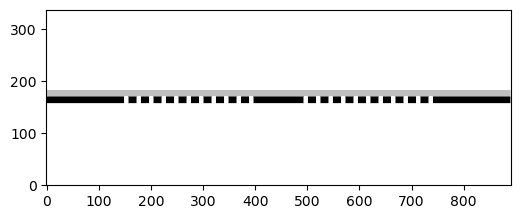

In [4]:
BE.get_epsilon() # Checking the geometry

-----------
Initializing structure...
time for choose_chunkdivision = 0.00662589 s
Working in Cylindrical dimensions.
Computational cell is 8.44 x 0 x 7.82 with resolution 50
     block, center = (4.216,0,0)
          size (8.432,0,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.1289,7.1289,7.1289)
     block, center = (4.216,0,-0.33)
          size (8.432,0,0.44)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (4.216,0,-0.625)
          size (8.432,0,0.15)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (4.216,0,0.21)
          size (8.432,0,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0.866,0,0)
          size (0.132,0,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diag

FloatProgress(value=0.0, description='0% done ', max=131.5)

on time step 63 (time=0.63), 0.0642696 s/step
on time step 132 (time=1.32), 0.057985 s/step
on time step 186 (time=1.86), 0.0746115 s/step
on time step 252 (time=2.52), 0.0613102 s/step
on time step 313 (time=3.13), 0.0658822 s/step
on time step 376 (time=3.76), 0.0650024 s/step
on time step 434 (time=4.34), 0.0691309 s/step
on time step 503 (time=5.03), 0.0581059 s/step
on time step 564 (time=5.64), 0.0662691 s/step
on time step 633 (time=6.33), 0.0579747 s/step
on time step 689 (time=6.89), 0.0728806 s/step
on time step 741 (time=7.41), 0.0775543 s/step
on time step 809 (time=8.09), 0.0589999 s/step
on time step 881 (time=8.81), 0.0561875 s/step
Meep progress: 9.31/131.5 = 7.1% done in 60.1s, 788.3s to go
on time step 938 (time=9.38), 0.0707882 s/step
on time step 986 (time=9.86), 0.0845156 s/step
on time step 1055 (time=10.55), 0.058385 s/step
on time step 1112 (time=11.12), 0.0708744 s/step
on time step 1181 (time=11.81), 0.0587888 s/step
on time step 1248 (time=12.48), 0.059834 s/

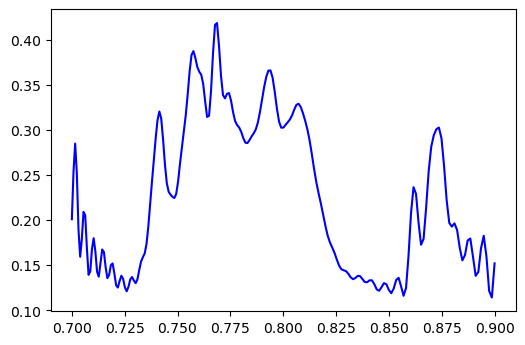

Peak at [[768.6695279]] nm


In [8]:
BE.get_ldos(time_after_source=100,nfreq_ldos=200)  # Checking the cavity mode

In [16]:
BE.end_simulation()

BE.define_cell(dpml, pad)
BE.define_geometry()
BE.define_point_sources(wvl_min=0.7,wvl_max=0.9,shift=0.1)  # Narrowband source centred at the frequency found before 
                                                             #(in practice we would always like it to be around 785nm anyway)
BE.define_simulation(res=100)

BE.define_box_monitors(wvl_flux_min=0.7, wvl_flux_max=0.9, box_distance=0.1, nfreq_box=200)

BE.get_qs()

-----------
Initializing structure...
time for choose_chunkdivision = 0.00081706 s
Working in Cylindrical dimensions.
Computational cell is 8.43 x 0 x 7.81 with resolution 100
     block, center = (4.216,0,0)
          size (8.432,0,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.1289,7.1289,7.1289)
     block, center = (4.216,0,-0.33)
          size (8.432,0,0.44)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (4.216,0,-0.625)
          size (8.432,0,0.15)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (4.216,0,0.21)
          size (8.432,0,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0.866,0,0)
          size (0.132,0,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon dia

FloatProgress(value=0.0, description='0% done ', max=181.5)

on time step 16 (time=0.08), 0.252986 s/step
on time step 34 (time=0.17), 0.231673 s/step
on time step 51 (time=0.255), 0.24263 s/step
on time step 71 (time=0.355), 0.202407 s/step
on time step 89 (time=0.445), 0.224469 s/step
on time step 107 (time=0.535), 0.223129 s/step
on time step 127 (time=0.635), 0.201809 s/step
on time step 145 (time=0.725), 0.224581 s/step
on time step 163 (time=0.815), 0.227093 s/step
on time step 183 (time=0.915), 0.202967 s/step
on time step 202 (time=1.01), 0.222019 s/step
on time step 220 (time=1.1), 0.223945 s/step
on time step 241 (time=1.205), 0.195121 s/step
on time step 259 (time=1.295), 0.230127 s/step
Meep progress: 1.36/181.5 = 0.7% done in 60.1s, 7964.3s to go
on time step 278 (time=1.39), 0.216001 s/step
on time step 298 (time=1.49), 0.20093 s/step
on time step 316 (time=1.58), 0.231071 s/step
on time step 334 (time=1.67), 0.223325 s/step
on time step 354 (time=1.77), 0.204801 s/step
on time step 372 (time=1.86), 0.226349 s/step
on time step 391